In [13]:
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import torch
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pylab as plt
from PIL import Image
import requests
from tqdm import tqdm

In [2]:
dataset = datasets.MNIST('../datasets',
                      train=False,
                      download=True,
                      transform=None)

In [28]:
test_results = torch.load("../datasets/test_explain.pt")

In [29]:
test_results.keys()

dict_keys(['true_label', 'pred_label', 'masks', 'batch_indices', 'attention_scores'])

In [31]:
test_results["batch_indices"].shape, test_results["true_label"].shape, test_results["attention_scores"].shape, test_results["masks"].shape

(torch.Size([32000, 15]),
 torch.Size([32000]),
 torch.Size([32000, 1, 15]),
 torch.Size([32000, 15]))

In [8]:
select_index = 100
test_results["batch_indices"][select_index]

tensor([ 890, 5165, 3362, 3328, 4303, 8182, 2433, 5530, 5416, 6489, 1824,  864,
        6388, 4134, 5627])

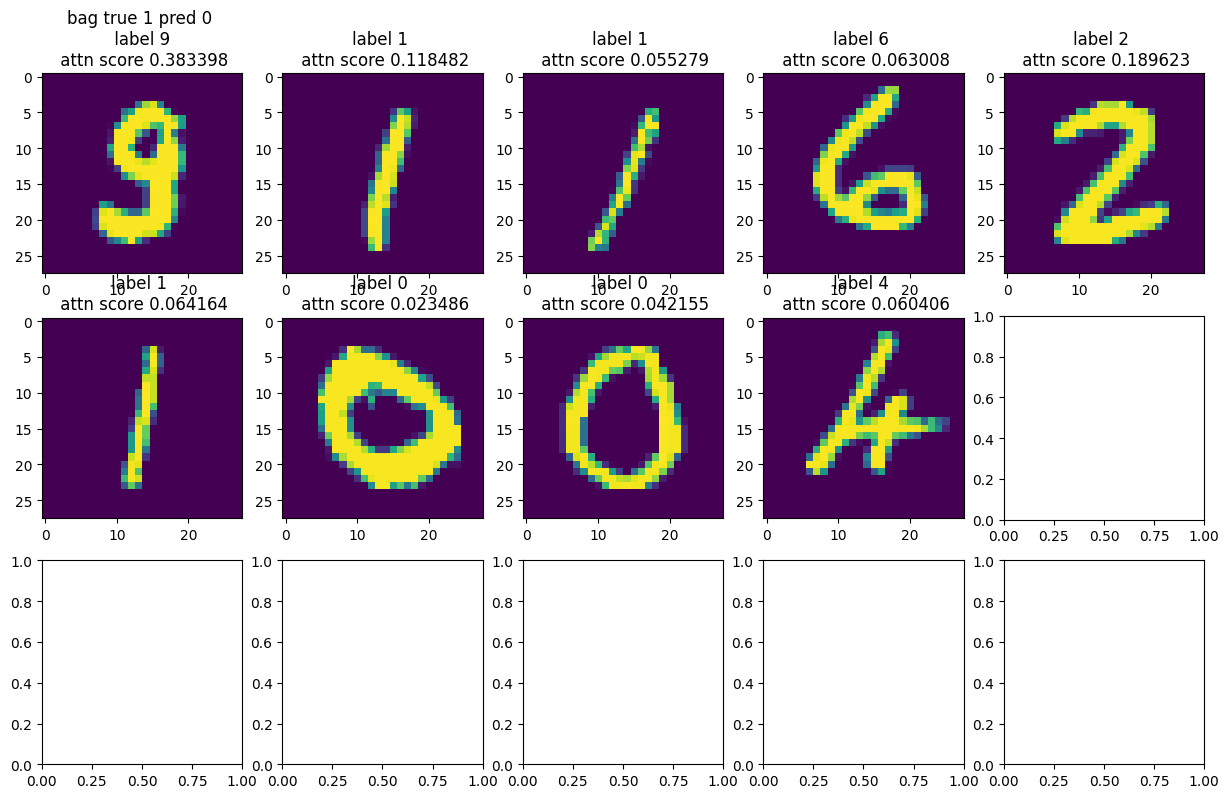

In [58]:
def plot_scores(row, test_results):
    batch_indices = test_results["batch_indices"][row]
    imgs = [dataset[i_][0] for i_ in batch_indices]
    labels = [dataset[i_][1] for i_ in batch_indices]
    true_label = test_results["true_label"][row]
    pred_label = test_results["pred_label"][row]
    n = int(torch.sum(test_results["masks"][row]))
    scores = test_results["attention_scores"][row].view(-1)
    fig, ax = plt.subplots(3, 5)
    fig.set_figwidth(15)
    fig.set_figheight(9)
    for i in range(n):
        ax[i//5][i%5].imshow(imgs[i])
        if i == 0:
            ax[i//5][i%5].set_title("bag true %i pred %i \n label %i \n attn score %f"%(true_label, pred_label, labels[i], scores[i]))
        else:
            ax[i//5][i%5].set_title("label %i \n attn score %f"%(labels[i], scores[i]))
plot_scores(283, test_results)

In [48]:
# len(torch.unique(test_results["batch_indices"].view(-1)))

In [56]:
torch.where(test_results["true_label"].eq(test_results["pred_label"]) == False)

(tensor([    1,   241,   283,   303,   337,   467,   550,   554,   613,   614,
           623,   640,   740,   772,   847,  1030,  1066,  1099,  1114,  1172,
          1202,  1222,  1248,  1303,  1396,  1468,  1507,  1631,  1674,  1724,
          1759,  1911,  1934,  1944,  1996,  2061,  2174,  2180,  2301,  2309,
          2356,  2390,  2442,  2549,  2570,  2580,  2627,  2694,  2695,  2742,
          2758,  2806,  2902,  2915,  2998,  3115,  3133,  3157,  3184,  3244,
          3293,  3411,  3457,  3518,  3557,  3577,  3642,  3671,  3709,  3719,
          3745,  3751,  3920,  4000,  4063,  4074,  4140,  4201,  4225,  4244,
          4253,  4266,  4270,  4331,  4375,  4458,  4564,  4623,  4656,  4726,
          4746,  4761,  4771,  4778,  4866,  4928,  4930,  4973,  4981,  5061,
          5073,  5077,  5135,  5184,  5200,  5201,  5217,  5252,  5291,  5295,
          5370,  5423,  5500,  5518,  5532,  5575,  5585,  5601,  5666,  5712,
          5781,  5797,  5840,  5863,  6000,  6005,  